In [5]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [6]:
df = pd.read_pickle('norm_all_data.pickle')
df = df.dropna()
df, test = train_test_split(df, test_size=10000, random_state=42)
train, valid = train_test_split(df, test_size=5000, random_state=42)

print( len(train), len(valid), len(test))

X_train = np.array(list( train['audio_data'] ))
y_train = np.array(train['song_hotttnesss']).reshape(-1, 1)

X_valid = np.array(list( valid['audio_data'] ))
y_valid = np.array(valid['song_hotttnesss']).reshape(-1, 1)

X_test = np.array(list( test['audio_data'] ))
y_test = np.array(test['song_hotttnesss']).reshape(-1, 1)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

161783 5000 10000
(161783, 120, 28) (161783, 1)
(5000, 120, 28) (5000, 1)
(10000, 120, 28) (10000, 1)


In [7]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).astype(np.float64).mean()*100

In [11]:
batch_size = 64
time_per_cell = 10
skip_time = 5
time = 120
features_at_time = 28

num_nodes = [
    [time_per_cell*features_at_time, 32],
    [32, 32],
    [32, 32],
    [32, 32]
]

dropout = [1.0, 1.0, 1.0, 1.0]

num_unrollings = (time - time_per_cell) // skip_time

graph = tf.Graph()
with graph.as_default():
  
  # Inputs
  X_tr = tf.placeholder(tf.float32, shape=(batch_size, time, features_at_time))
  y_tr = tf.placeholder(tf.float32, shape=(batch_size, 1))
  X_te = tf.constant(X_test.astype(np.float32))
  X_val = tf.constant(X_valid.astype(np.float32))
    
  tr_inputs = []
  for i in range(num_unrollings):
    tr_inputs.append(tf.reshape( X_tr[:, skip_time*i:skip_time*i+time_per_cell], (batch_size, -1) ))
    
  val_inputs = []
  for i in range(num_unrollings):
    val_inputs.append(tf.reshape( X_val[:, skip_time*i:skip_time*i+time_per_cell], (X_val.shape[0], -1) ))
    
  te_inputs = []
  for i in range(num_unrollings):
    te_inputs.append(tf.reshape( X_te[:, skip_time*i:skip_time*i+time_per_cell], (X_test.shape[0], -1) ))

  # Variables
  w = []
  b = []
  for i, s in enumerate(num_nodes):
    w.append(tf.Variable(tf.truncated_normal((s[0]+s[1], 4*s[1]), stddev=0.1), name='w'+str(i)))
    b.append(tf.Variable(tf.zeros([4*s[1]]), name='b'+str(i)))
    
  w_dense = tf.Variable(tf.truncated_normal((num_nodes[-1][-1], 1), stddev=1.0), name='w_dense')
  b_dense = tf.Variable(tf.zeros(1), name='b_dense')
    
  #w_hat = tf.Variable(tf.truncated_normal((num_unrollings, 1), stddev=1.0))
  #b_hat = tf.Variable(tf.zeros(1))

  # Definition of the cell computation.
  # m = tf.matmul(tf.concat([i, o], axis=1), w) + b
  def lstm_cell(m, state):
    i, f, c, o = tf.split(m, num_or_size_splits=4, axis=1)
    input_gate = tf.sigmoid(i)
    forget_gate = tf.sigmoid(f)
    state = forget_gate * state + input_gate * tf.tanh(c)
    output_gate = tf.sigmoid(o)
    return output_gate * tf.tanh(state), state

  # Unrolling
  def unrolling(inputs, training=False):
    states = []
    outputs = []
    #ans = []
    for i in range(len(w)):
      states.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
      outputs.append(tf.zeros([inputs[0].get_shape()[0], num_nodes[i][1]]))
    for j in range(num_unrollings):
      for i in range(len(w)):
        if i==0: inp = inputs[j]
        else:
            if training:
                inp = tf.nn.dropout(outputs[i-1], dropout[i-1])
            else:
                inp = outputs[i-1]
        m = tf.nn.xw_plus_b(tf.concat((inp, outputs[i]), axis=1), w[i], b[i])
        outputs[i], states[i] = lstm_cell(m, states[i])
      #ans.append(
      #    tf.nn.relu(
      #        tf.nn.xw_plus_b(outputs[-1], w_dense, b_dense)))
    #return tf.transpose( tf.reshape(ans, [num_unrollings, inputs[0].get_shape()[0]]) )
    return tf.nn.xw_plus_b(outputs[-1], w_dense, b_dense)

  tr_outputs = unrolling(tr_inputs, True) #tf.nn.xw_plus_b( unrolling(tr_inputs, True), w_hat, b_hat )
  tr_outputs2 = unrolling(tr_inputs) #tf.nn.xw_plus_b( unrolling(tr_inputs), w_hat, b_hat )
  val_outputs = unrolling(val_inputs) #tf.nn.xw_plus_b( unrolling(val_inputs), w_hat, b_hat )
  te_outputs = unrolling(te_inputs) #tf.nn.xw_plus_b( unrolling(te_inputs), w_hat, b_hat )

  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tr, logits=tr_outputs))

  # Optimizer.
  #global_step = tf.Variable(0)
  #learning_rate = tf.train.exponential_decay(
  #  1e-1, global_step, 500, 0.1, staircase=True)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  #gradients, v = zip(*optimizer.compute_gradients(loss))
  #gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  #optimizer = optimizer.apply_gradients(
  #  zip(gradients, v), global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(1e-3).minimize(loss)
  optimizer = tf.train.AdamOptimizer(3e-4).minimize(loss)

  # Predictions.
  tr_pred = tf.nn.sigmoid(tr_outputs2)
  val_pred = tf.nn.sigmoid(val_outputs)
  te_pred = tf.nn.sigmoid(te_outputs)

  # Save
  saver = tf.train.Saver()

Initialized
Avg loss at step 0: 0.691928
Avg accuracy: 59.4%
Validation accuracy: 49.9%
Avg loss at step 100: 0.656217
Avg accuracy: 52.8%
Validation accuracy: 57.0%
Avg loss at step 200: 0.645860
Avg accuracy: 57.4%
Validation accuracy: 57.8%
Avg loss at step 300: 0.645335
Avg accuracy: 57.6%
Validation accuracy: 57.5%
Avg loss at step 400: 0.647227
Avg accuracy: 58.2%
Validation accuracy: 57.8%
Avg loss at step 500: 0.649176
Avg accuracy: 57.2%
Validation accuracy: 57.9%
Avg loss at step 600: 0.644856
Avg accuracy: 58.1%
Validation accuracy: 57.9%
Avg loss at step 700: 0.642907
Avg accuracy: 58.9%
Validation accuracy: 58.2%
Avg loss at step 800: 0.644544
Avg accuracy: 58.8%
Validation accuracy: 57.3%
Avg loss at step 900: 0.644301
Avg accuracy: 58.5%
Validation accuracy: 58.1%
Avg loss at step 1000: 0.644408
Avg accuracy: 58.3%
Validation accuracy: 58.0%
Avg loss at step 1100: 0.644800
Avg accuracy: 58.8%
Validation accuracy: 58.2%
Avg loss at step 1200: 0.643858
Avg accuracy: 58.9%


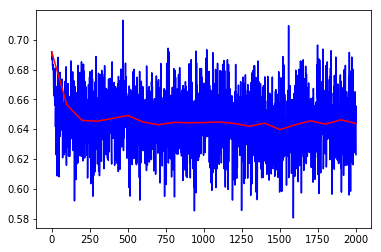

In [15]:
num_steps = 2001

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  preds = 0
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :]
    batch_labels = y_train[offset:(offset + batch_size)]
    feed_dict = {X_tr : batch_data, y_tr : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tr_pred], feed_dict=feed_dict)
    losses.append(l)
    preds += accuracy(predictions, batch_labels)
    if (step % 100 == 0):
      #print(predictions)
      if step==0: preds *= 100
      avg.append(sum(losses[-100:])/len(losses[-100:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Avg accuracy: %.1f%%' % (preds / 100))
      preds = 0
      print('Validation accuracy: %.1f%%' % accuracy(val_pred.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(te_pred.eval(), y_test))
  saver.save(session, './RNN', write_meta_graph=False)
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*100, avg, 'r')
  plt.show()